# Investigate changes in the Krill Growth Potential simulated by the CESM-LE

In [1]:
%matplotlib inline
import os
import shutil

from glob import glob

import cftime

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import intake
import pop_tools

import util

Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


## Spin up dask cluster

In [2]:
from ncar_jobqueue import NCARCluster
cluster = NCARCluster(memory='100 GB')
cluster.scale(32)
cluster

In [3]:
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client

Client Scheduler: tcp://10.12.205.22:35530 Dashboard: https://jupyterhub.ucar.edu/dav/user/mclong/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Get the model grid for subsetting in latitude
Where we are using the [pop_tools](https://pop-tools.readthedocs.io/en/latest/examples/get-model-grid.html) package. This reads the same binary files that the model read to generate the grid online.

In [4]:
grid = pop_tools.get_grid('POP_gx1v6')
grid

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    DXU          (nlat, nlon) float64 2.397e+06 2.397e+06 ... 1.391e+06
    DYU          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.493e+06 5.493e+06
    TAREA        (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.432e+12
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
Attributes:
    lateral_dims:         [384, 320]
    vertical_dims:        60
    vert_grid_file:       gx1v7_vert_grid
    horiz_grid_fname:     inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ie...
    topography_fname:     inputdata/ocn/pop/gx1v6/grid/topography_20090204.ie...
    region_mask_fname:    inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.i...
    type:                 dipole
    region_mask_regions:  {'Caspian Sea': -14, 'Black Sea': -13, 'Baltic Sea'...
    title:                POP_gx1v6 grid

Find the portion of the domain that is south of 30°S.
Create a `slice` object corresponding to this region.

First, let's visualize the `TLAT` array.

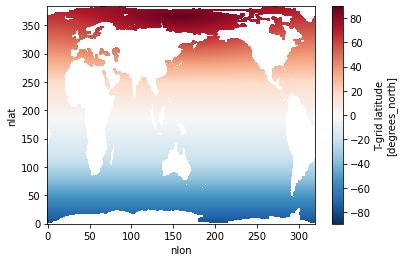

In [5]:
grid.TLAT.where(grid.KMT>0).plot();

The model is a regular lat x lon grid in the southern hemisphere, this we can just use the first column of the `TLAT` array; all other columns are identical.

In [6]:
jnx = np.where(grid.TLAT[:, 0] <= -30)[0]
lat_slice = slice(jnx[0], jnx[-1]+1)
lat_slice

slice(0, 93, None)

Make a quick-look plot of the regions.

## Read the CESM-LE data 

We will use [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/), which is a data catalog tool.
It enables querying a database for the files we want, then loading those directly as an `xarray.Dataset`.

First step is to set the "collection" for the CESM-LE, which depends on a json file conforming to the [ESM Catalog Specification](https://github.com/NCAR/esm-collection-spec).

In [7]:
catalog_file = './data/glade-cesm1-le.json'
variables = ['SST', 'diatChl', 'spChl', 'diazChl', 'IFRAC',]# 'Jint_100m_DIC', 
#             'photoC_sp', 'photoC_diat', 'photoC_diaz']

experiments = ['20C', 'RCP85']
stream = 'pop.h'
    
col = intake.open_esm_datastore(catalog_file, sep=',')
col

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


null:
  args:
    esmcol_obj: ./data/glade-cesm1-le.json
    sep: ','
  description: ''
  driver: intake_esm.core.esm_datastore
  metadata: {}


Now we will search the collection for the ensemble members (unique `member_id`'s) that have a chlorophyll field. This is necessary because the ocean biogeochemistry was corrupted in some members and the data deleted.

In this cell, `member_id` is a list of the ensemble members we want to operate on.

In [8]:
col_sub = col.search(experiment=['20C'],                      
                     stream='pop.h', 
                     variable=['diatChl'])

member_id = list(col_sub.df.member_id.unique())
print(member_id)

[1, 2, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 101, 102, 103, 104, 105]


## Now let's search for the data we want

Specify a list of variables and perform a search. Under the hood, the `search` functionality uses [`pandas`](https://pandas.pydata.org/) data frames. We can view that frame here using the `.df` syntax.

In [9]:
col_sub = col.search(
    experiment=experiments, 
    stream=stream, 
    variable=variables,
    member_id=member_id,
    )

print(col_sub)

col_sub.df.head()

<glade-cesm1-le catalog with 2 dataset(s) from 475 asset(s)>


,experiment,case,component,stream,variable,date_range,member_id,path,ctrl_branch_year,ctrl_experiment,ctrl_member_id
0,20C,b.e11.B20TRC5CNBDRD.f09_g16.001,ocn,pop.h,IFRAC,185001-200512,1,/glade/campaign/cesm/collections/cesmLE/CESM-C...,402,CTRL,1
1,20C,b.e11.B20TRC5CNBDRD.f09_g16.002,ocn,pop.h,IFRAC,192001-200512,2,/glade/campaign/cesm/collections/cesmLE/CESM-C...,1920,20C,1
2,20C,b.e11.B20TRC5CNBDRD.f09_g16.009,ocn,pop.h,IFRAC,192001-200512,9,/glade/campaign/cesm/collections/cesmLE/CESM-C...,1920,20C,1
3,20C,b.e11.B20TRC5CNBDRD.f09_g16.010,ocn,pop.h,IFRAC,192001-200512,10,/glade/campaign/cesm/collections/cesmLE/CESM-C...,1920,20C,1
4,20C,b.e11.B20TRC5CNBDRD.f09_g16.011,ocn,pop.h,IFRAC,192001-200512,11,/glade/campaign/cesm/collections/cesmLE/CESM-C...,1920,20C,1


Now we can use the [`to_dataset_dict`](https://intake-esm.readthedocs.io/en/latest/api.html#intake_esm.core.esm_datastore.to_dataset_dict) method to return a dictionary of `xarray.Dataset`'s. `intake_esm` makes groups of these according to rules in the collection spec file.

We can use the `preprocess` parameter to pass in a function that makes some corrections to the dataset. So first we define a function that does the following:
- fix the time coordinate to be the middle of the interval
- drop the singleton dimension on SST (which screws up coordinate alignment)
- subset to the time-interval 1920-2100

In [10]:
def fix_sst_time_and_subset(ds):
    """Fix some things in the dataset and subset in space"""   
    grid_vars = ['KMT', 'TAREA', 'TLAT', 'TLONG', 'z_t', 'dz', 'z_t_150m', 'time', 'time_bound']

    if 'SST' in ds:
        ds['SST'] = ds.SST.isel(z_t=0, drop=True)
             
    data_vars = list(filter(lambda v: v in variables, ds.data_vars))
    
    ds = ds[data_vars+grid_vars].isel(nlat=lat_slice)
    
    # set grid variables to coordinates to ease concatenation in intake-esm
    new_coords = set(grid_vars) - set(ds.coords)

    return ds.set_coords(new_coords)

In [ ]:
%%time
dsets = col_sub.to_dataset_dict(cdf_kwargs={'chunks': {'time': 60}, 'decode_times': False},
                                preprocess=fix_sst_time_and_subset)
dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component,experiment,stream'


Now, let's compute the total surface chlorophyll, put time at the mid-point of the interval, and subset to 1920-2100.

In [ ]:
def compute_chl_surf(ds):
    """compute surface chl"""

    ds['Chl_surf'] = (ds.diatChl + ds.spChl + ds.diazChl).isel(z_t_150m=0)
    ds.Chl_surf.attrs = ds.diatChl.attrs
    ds.Chl_surf.attrs['long_name'] = 'Surface chlorophyll'

    return ds.drop(['diatChl', 'spChl', 'diazChl'])

def compute_NPP_zint(ds):
    """compute surface chl"""
    
    dz150m = ds.dz.isel(z_t=slice(0, 15)).rename({'z_t': 'z_t_150m'})
    ds['NPP'] = ((ds.photoC_diat + ds.photoC_sp + ds.photoC_diaz) * dz150m).sum(dim='z_t_150m')
    ds.NPP.attrs = ds.photoC_diat.attrs
    ds.NPP.attrs['long_name'] = 'NPP'
    ds.NPP.attrs['units'] = ds.NPP.attrs['units'] + ' cm'
    
    return ds.drop(['photoC_diat', 'photoC_sp', 'photoC_diaz'])


def fix_time(ds):
    ds = ds.copy(deep=True)
    ds['time'] = xr.DataArray(cftime.num2date(ds.time_bound.mean(dim='d2'), units=ds.time.units, 
                                              calendar=ds.time.calendar), dims=('time'))
    return ds    

In [ ]:
# fix time
dsets2 = {key: fix_time(ds) for key, ds in dsets.items()}

# subset time
dsets2 = {key: ds.sel(time=slice('1920', '2100')) for key, ds in dsets2.items()}

# compute surface chl
dsets2 = {key: compute_chl_surf(ds) for key, ds in dsets2.items()}

# compute NPP
#dsets2 = {key: compute_NPP_zint(ds) for key, ds in dsets2.items()}

dsets2

Concatenate the datasets in time, i.e. 20C + RCP8.5 experiments.

In [ ]:
ordered_dsets_keys = ['ocn,20C,pop.h', 'ocn,RCP85,pop.h']
ds = xr.concat(
    [dsets2[exp] for exp in ordered_dsets_keys], 
    dim='time', 
    data_vars='minimal'
)
ds

## Apply bias correction

In [ ]:
name_sst_obs = 'HadISST'

ds_obs_sst = xr.open_dataset('/glade/work/mclong/HadISST/HadISST_sst_POP_gx1v6.nc', use_cftime=True)
ds_obs_sst = ds_obs_sst.isel(nlat=lat_slice)
ds_obs_sst = ds_obs_sst.sel(time=slice('1981', '2015')).drop(['TLAT', 'TLONG'])
ds_obs_sst

In [ ]:
sst_obs_mean = ds_obs_sst.sst.groupby('time.month').mean('time')
sst_obs_mean

In [ ]:
sst_obs_std = ds_obs_sst.sst.groupby('time.month').std('time')
sst_obs_std

In [ ]:
sst_mod = ds.SST.sel(time=slice('1981', '2015'))
sst_mod = sst_mod.drop(['TLONG', 'TLAT', 'KMT', 'ULAT', 'ULONG', 'TAREA'])
sst_mod = sst_mod.compute()
sst_mod

In [ ]:
sst_mod_mean = sst_mod.groupby('time.month').mean(['time', 'member_id'])
sst_mod_mean = sst_mod_mean.compute()
sst_mod_mean

In [ ]:
sst_mod_std = sst_mod.groupby('time.month').std(['time', 'member_id'])
sst_mod_std = sst_mod_std.compute()
sst_mod_std

In [ ]:
da = ds.SST.drop(['TLONG', 'TLAT', 'KMT', 'ULAT', 'ULONG', 'TAREA'])

zscore = ((da.groupby('time.month') - sst_mod_mean)
          .groupby('time.month') / sst_mod_std)

sst_bias_corr = ((zscore.groupby('time.month') * sst_obs_std)
                 .groupby('time.month') + sst_obs_mean)

sst_bias_corr

In [ ]:
ds.SST.sel(time=slice('1981', '2015')).isel(member_id=0, nlat=30, nlon=200).plot(label='original data')
sst_bias_corr.sel(time=slice('1981', '2015')).isel(member_id=0, nlat=30, nlon=200).plot(label='bias corr')
ds_obs_sst.sst.isel(nlat=30, nlon=200).plot(label='obs')
plt.legend();

In [ ]:
ds.SST.isel(member_id=0, nlat=30, nlon=200).plot(label='original data')
sst_bias_corr.isel(member_id=0, nlat=30, nlon=200).plot(label='bias corr')
ds_obs_sst.sst.isel(nlat=30, nlon=200).plot(label='obs')
plt.legend();

In [ ]:
ds = ds.rename(SST='SST_orig')
ds['SST'] = sst_bias_corr
ds.SST.attrs = ds.SST_orig.attrs
ds.SST.attrs['note'] = f'bias corrected using {name_sst_obs}; reference period 1981-2015'
ds

## Compute Krill Growth Potential

Define a "length" coordinate.

In [ ]:
length = xr.DataArray(
    [20., 40., 60.], 
    name='length',
    dims=('length'), 
    attrs={'units': 'mm', 'long_name': 'Krill body length'})
length

Perform the actual computation

In [ ]:
ds = util.compute_kgp(ds, length)
ds

## Compute summer time (DJF) means 

In [ ]:
%%time
ds_djf = util.ann_mean(ds, season='DJF', time_bnds_varname='time_bound')
ds_djf

In [ ]:
%%time
ds_ann = util.ann_mean(ds, time_bnds_varname='time_bound')
ds_ann

In [ ]:
%%time
dso_map = {
    f'{util.project_tmpdir}/cesm-le-fields-djf.zarr': ds_djf.chunk({
        'time': -1, 
        'member_id': 1, 
        'nlat': -1, 
        'nlon': -1,
        'length': -1,
    }
    ), 
    f'{util.project_tmpdir}/cesm-le-fields-ann.zarr': ds_ann.chunk({
        'time': -1, 
        'member_id': 1, 
        'nlat': -1, 
        'nlon': -1,
        'length': -1,
    }
    ),     
}
for file_out, dso in dso_map.items():
    util.write_ds_out(dso, file_out)